<div class="alert alert-block alert-info">
<b>GPT Parameters:</b> 124M Parameter GPT, same as GPT-2
</div>

In [4]:
GPT_config = {"Vocab_size": 50275,    # Total Byte-Pair encodding dictionary size
            "Context_lenght": 1024,   # Length of Input context at a time
            "embedding_dim": 768,     # Total embedding dimension 
            "Number_of_heads": 12,    # Total number of heads in Multihead Attention Mechanis
            "Number_of_layers": 12,   # Toral number of transformer blocks
            "Dropout_rate": 0.1,      # Neuron drop out rate
            "QKV_bias": False         # Query, Key and Value bias
             }

In [5]:
import torch

In [81]:
inputs = torch.tensor(
    [[-10.43, 0.15, 0.89, 0.55, 0.87, 0.66],  # Row 1
     [0.57, 0.85, 0.64, 0.22, 0.58, 0.33],  # Row 2
     [0.77, 0.25, 0.10, 0.05, 0.80, 0.55]])

<div class="alert alert-block alert-success">
<b>Layer Normalization Class:</b> Used to normalize input rows to mean of zero 
    and a standard deviation of 1
</div>

In [82]:
class Layer_Normalization(torch.nn.Module):
    
    def __init__(self, emb_dim):
        super().__init__()
        
        self._epsilon = 1e-5 # to prevent zero division error
        self._scaling = torch.nn.Parameter(torch.ones(emb_dim)) 
        self._shift = torch.nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self,X):
        
        mean = torch.mean(X, dim=-1, keepdim =True)
        var = torch.var(X, dim=-1, keepdim=True, unbiased = False)
        Normalized_X = (X - mean)/torch.sqrt(var + self._epsilon)
        
        return Normalized_X*self._scaling + self._shift

<div class="alert alert-block alert-success">
<b>GELU Activation Class:</b> Numerican Approximation is used to calculate GELU Activation
</div>

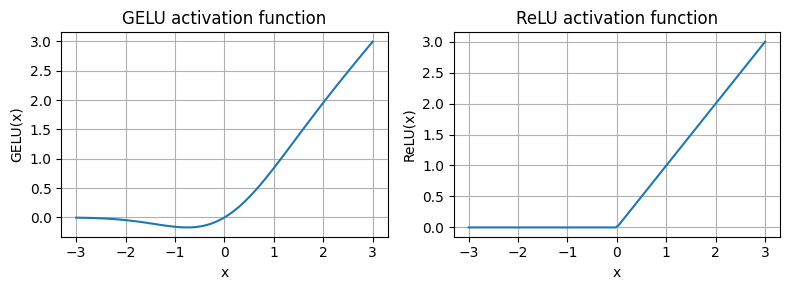

In [83]:
class GELU_Activation(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))                                           

<div class="alert alert-block alert-success">
<b>Feed Forward Class:</b> Bump up the dimension to 4 times the embedding dimesion 
    then lower it to actual dimension
</div>

In [84]:
class Feed_Forward(torch.nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self._Model = torch.nn.Sequential(torch.nn.Linear(emb_dim, 4*emb_dim), GELU_Activation(),
                            torch.nn.Linear(4*emb_dim, emb_dim)
                           )
    def forward(self,X):
        return self._Model(X)                  

<div class="alert alert-block alert-success">
<b>Multihead Attention:</b> Creates a reation between encoded ids
</div>

In [85]:
class Multihead_Attention(torch.nn.Module):
    
    def __init__(self, dim_in, dim_out, num_heads, dropout): # let just assume what out dimension we want
        super().__init__()
        self._dim_out = dim_out
        self._QueryW = torch.nn.Linear(dim_in, dim_out,bias = False) # Initialize the weights for Query, Key and Value weights
        self._KeyW = torch.nn.Linear(dim_in, dim_out,bias= False)
        self._ValueW = torch.nn.Linear(dim_in, dim_out,bias = False)
        
        self._Dropout = torch.nn.Dropout(dropout)
        
        # Initialize number of heads
        self._heads = num_heads
        # Remainder that to be zero, equal spitting of heads into dimensions
        assert (dim_out%self._heads == 0), "Has to be divisible"
        self._head_dimensions = dim_out//num_heads
        
        
        
    def forward(self,X):  
        # X.shape[0] = batch_size, X.shape[1] = tot_embedding, X.shape[2] = dim_in
        batch_size, tot_embedding, dim_in = X.shape
        # calculation for Query, Key and Value matrix
        Query = self._QueryW(X)
        Key = self._KeyW(X)
        Value = self._ValueW(X)
        
        # The transition to split it in number of heads and dimensions
        Query = Query.view(batch_size, tot_embedding, self._heads, self._head_dimensions)
        Key = Key.view(batch_size, tot_embedding, self._heads, self._head_dimensions)
        Value = Value.view(batch_size, tot_embedding, self._heads, self._head_dimensions)
        
        # Transpose the position of tot_embedding with total number of heads
        Query = Query.transpose(1,2)
        Key = Key.transpose(1,2)
        Value = Value.transpose(1,2)
        
        attention_score = Query @ Key.transpose(2,3)
        
        # Initialization of mask
        mask = torch.tril(torch.ones(tot_embedding,tot_embedding))
        
        # Normalization of attention_score
        attention_score_normalized = torch.softmax(attention_score/Key.shape[-1]**0.5, dim=-1) 
        
        # Masking the attention_score
        attention_score_masked = attention_score_normalized * mask
        
        # Normalization to 1
        attention_weights = attention_score_masked/torch.sum(attention_score_masked, dim =-1, keepdim = True)
        
        attention_weights = self._Dropout(attention_weights)
        
        # Context_vector calculation
        ### Transpose the context vector to rearrange and get number of heads close to head_dimensions
        context_vector = (attention_weights @ Value).transpose(1,2)
        
        
        context_vector = context_vector.contiguous().view(batch_size, tot_embedding, self._dim_out)
        
        
        return context_vector

<div class="alert alert-block alert-success">
<b>Transformer Block:</b> X - Layer Normalization - Multihead - Dropout - Add Shortcut - Layer Normalization2 - 
    Feed Forward(GELU Activation) - Dropout - Add Shortcut
</div>

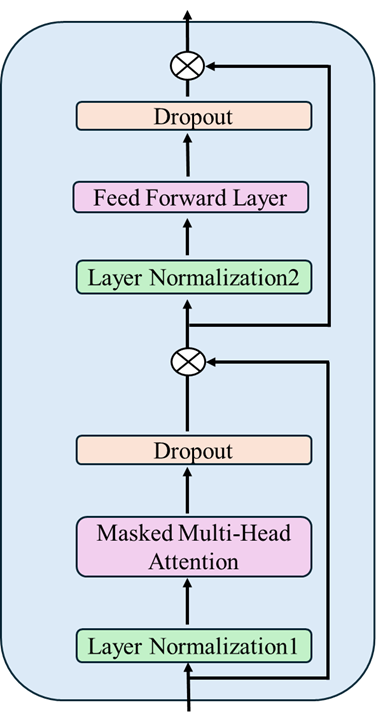

In [86]:
class Transformer_Block(torch.nn.Module):
    
    def __init__(self, GPT_config):
        super().__init__()
        ##### Takes tensor in forward method ##### Test with tensor
        self._Multihead_Attention = Multihead_Attention(GPT_config["embedding_dim"], # dim_in = dim_out
                                                        GPT_config["embedding_dim"],
                                                        GPT_config["Number_of_heads"],
                                                        GPT_config["Dropout_rate"])
        
        self._Layer_Normalization1 = Layer_Normalization(GPT_config["embedding_dim"]) # Linear Normalization Layer
        self._Layer_Normalization2 = Layer_Normalization(GPT_config["embedding_dim"])
        
        self._Feed_Forward = Feed_Forward(GPT_config["embedding_dim"]) # Expansion and contraction layer
        
        self._Dropout_Short = torch.nn.Dropout(GPT_config["Dropout_rate"]) # drop out step
        
        
    def forward(self, X):
        
        shortcut = X                                # seperate line for the short cut
        
        X = self._Layer_Normalization1(X)           # First Layer Normalization
        
        X = self._Multihead_Attention(X)             # Pass through Multihead Attention
        
        X = self._Dropout_Short(X)                  # Drop some Neurons
        
        X = X + shortcut                             # Merge with the shortcut from the input
        
        ## Second stage of transformer 
        
        shortcut = X
        
        X = self._Layer_Normalization2(X)
        
        X = self._Feed_Forward(X)
        
        X = self._Dropout_Short(X)
        
        X = X + shortcut
        
        return X       

In [87]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = Transformer_Block(GPT_config)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


<div class="alert alert-block alert-success">
<b>GPT Block:</b> Integrates Embedding to Transformer block and then to output
</div>

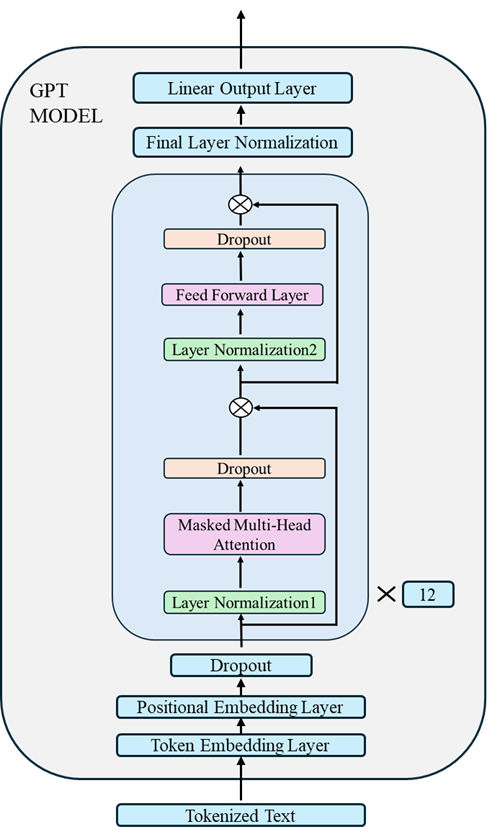

In [91]:
class GPT_Model(torch.nn.Module):
    def __init__(self, GPT_config):
        super().__init__()
        
        self._Embeddings = torch.nn.Embedding(GPT_config['Vocab_size'],
                                             GPT_config['embedding_dim'])
        self._Positional_Embedding = torch.nn.Embedding(GPT_config['Context_lenght'],
                                             GPT_config['embedding_dim'])
        self._Dropout = torch.nn.Dropout(GPT_config['Dropout_rate'])
        
        # Transformer step
        self._Transformer = torch.nn.Sequential(
                                        *[Transformer_Block(GPT_config) for _ in range(GPT_config['Number_of_layers'])])
        
        # Output steps
        self._LayerNormalization = Layer_Normalization(GPT_config['embedding_dim'])
        self._Out = torch.nn.Linear(GPT_config['embedding_dim'], GPT_config['Vocab_size'])
        
    def forward(self, ids):                         # Here X is input of dimension Batch size and context lenght
        
        batch_size, context_len = ids.shape
        
        token_embedding = self._Embeddings(ids)     # X become 3 dimensional tensor Batch size, context length and embedding dim 
        positional_embedding = self._Positional_Embedding(torch.arange(context_len, device = ids.device))
        
        X = token_embedding + positional_embedding # Add the positional embedding
        
        X = self._Dropout(X)                       # Drop out 
        X = self._Transformer(X)                   # Pass through the transformer             
        
        X = self._LayerNormalization(X)            # layer Normalization, mean = 0, standard deviation = 1
        logits = self._Out(X)
        
        return logits 

In [ ]:
torch.arange(1024, )